In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import random
from itertools import product
from scipy import stats
sns.set(rc={"figure.figsize":(13, 9)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Find and Replace Current GDP PC PPP Data
The World Happiness Report (WH) 2022 has been released before the official 2021 GDP data of countries were available. Hence estimations were used. Here they will be replaced with the real ones. Additionally, there are missing GDP per capita PPP (which will be called as simply GDP in this notebook) information, I expect some of the nulls to disappear.

In [2]:
wh = pd.read_excel("data/WHR2022.xls")
wh

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.302574        0.450662   
1     Afghanistan  2009     4.401778            7.472446        0.552308   
2     Afghanistan  2010     4.758381            7.579183        0.539075   
3     Afghanistan  2011     3.831719            7.552006        0.521104   
4     Afghanistan  2012     3.782938            7.637953        0.520637   
...           ...   ...          ...                 ...             ...   
2084     Zimbabwe  2017     3.638300            8.241609        0.754147   
2085     Zimbabwe  2018     3.616480            8.274620        0.775388   
2086     Zimbabwe  2019     2.693523            8.196998        0.759162   
2087     Zimbabwe  2020     3.159802            8.117733        0.717243   
2088     Zimbabwe  2021     3.154578            8.153248        0.685151   

      Healthy life expectancy at birth  Freedom to make life choices  \
0                            50.500000                      0.718114   
1                            50.799999                      0.678896   
2                            51.099998                      0.600127   
3                            51.400002                      0.495901   
4                            51.700001                      0.530935   
...                                ...                           ...   
2084                         52.150002                      0.752826   
2085                         52.625000                      0.762675   
2086                         53.099998                      0.631908   
2087                         53.575001                      0.643303   
2088                         54.049999                      0.667636   

      Generosity  Perceptions of corruption  Positive affect  Negative affect  \
0       0.173169                   0.881686         0.414297         0.258195   
1       0.195469                   0.850035         0.481421         0.237092   
2       0.125859                   0.706766         0.516907         0.275324   
3       0.167723                   0.731109         0.479835         0.267175   
4       0.241247                   0.775620         0.613513         0.267919   
...          ...                        ...              ...              ...   
2084   -0.113937                   0.751208         0.733641         0.224051   
2085   -0.084747                   0.844209         0.657524         0.211726   
2086   -0.081540                   0.830652         0.658434         0.235354   
2087   -0.029376                   0.788523         0.660658         0.345736   
2088   -0.109439                   0.756945         0.609917         0.241682   

      Confidence in national government  
0                              0.612072  
1                              0.611545  
2                              0.299357  
3                              0.307386  
4                              0.435440  
...                                 ...  
2084                           0.682647  
2085                           0.550508  
2086                           0.456455  
2087                           0.577302  
2088                           0.665703  

[2089 rows x 12 columns]

Let us check the empty GDP values of 2021. In total 8 missing. As the Generosity is also calculated using the GDP, whenever GDP is missing, so is Generosity.

In [3]:
wh[(wh.year == 2021) & (wh["Log GDP per capita"].isna())]

Country name  year  Life Ladder  Log GDP per capita  \
12                  Afghanistan  2021     2.436034                 NaN   
463                      Cyprus  2021     6.269202                 NaN   
758   Hong Kong S.A.R. of China  2021     5.321551                 NaN   
985                      Kosovo  2021     6.648499                 NaN   
1165                      Malta  2021     6.443715                 NaN   
1647                  Singapore  2021     6.586717                 NaN   
1802   Taiwan Province of China  2021     6.246744                 NaN   
2029                  Venezuela  2021     5.107553                 NaN   

      Social support  Healthy life expectancy at birth  \
12          0.454175                         54.549999   
463         0.855357                         72.800003   
758         0.821089                               NaN   
985         0.848839                               NaN   
1165        0.897113                         71.599998   
1647        0.876409                         73.800003   
1802        0.866298                               NaN   
2029        0.812418                         64.050003   

      Freedom to make life choices  Generosity  Perceptions of corruption  \
12                        0.394306         NaN                   0.946299   
463                       0.717639         NaN                   0.876456   
758                       0.668631         NaN                   0.389589   
985                       0.840117         NaN                   0.842379   
1165                      0.889074         NaN                   0.752516   
1647                      0.878701         NaN                   0.144935   
1802                      0.818467         NaN                   0.675439   
2029                      0.595620         NaN                   0.823898   

      Positive affect  Negative affect  Confidence in national government  
12           0.178886         0.606713                           0.255620  
463          0.641121         0.274684                           0.321940  
758          0.534148         0.223565                           0.495274  
985          0.578284         0.116078                           0.577199  
1165         0.635254         0.375325                           0.662025  
1647         0.696990         0.159802                           0.897622  
1802         0.667417         0.122980                           0.437148  
2029         0.697587         0.389351                           0.175912

Read GDP per capita PPP data downloaded from World Bank. We only need the year 2021.

In [4]:
gdp_pc_ppp_21 = pd.read_csv("data/API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_4639881.csv", skiprows=4)[["Country Name","2021"]]
gdp_pc_ppp_21

Country Name          2021
0                          Aruba           NaN
1    Africa Eastern and Southern   3556.353833
2                    Afghanistan           NaN
3     Africa Western and Central   4073.357927
4                         Angola   5990.416805
..                           ...           ...
261                       Kosovo  11579.320348
262                  Yemen, Rep.           NaN
263                 South Africa  13126.014738
264                       Zambia   3298.626768
265                     Zimbabwe   2225.094972

[266 rows x 2 columns]

Before joining need to check some special cases

In [5]:
gdp_pc_ppp_21[gdp_pc_ppp_21["Country Name"].str.contains("China")]

Country Name          2021
40                  China  17602.696058
96   Hong Kong SAR, China  60051.754851
146      Macao SAR, China  67178.744745

Replace the "SAR, China" as it does not exactly match to World Bank data.

In [6]:
gdp_pc_ppp_21["Country Name"] = gdp_pc_ppp_21["Country Name"].str.replace(" SAR, China", "",regex=False)

Melt the data for easier join with WH data

In [7]:
gdp_ppp = gdp_pc_ppp_21.melt(id_vars=["Country Name"], value_name="GDP PPP")
gdp_ppp.rename(columns={"variable":"year"}, inplace=True)
gdp_ppp.year = gdp_ppp.year.astype(int)
gdp_ppp

Country Name  year       GDP PPP
0                          Aruba  2021           NaN
1    Africa Eastern and Southern  2021   3556.353833
2                    Afghanistan  2021           NaN
3     Africa Western and Central  2021   4073.357927
4                         Angola  2021   5990.416805
..                           ...   ...           ...
261                       Kosovo  2021  11579.320348
262                  Yemen, Rep.  2021           NaN
263                 South Africa  2021  13126.014738
264                       Zambia  2021   3298.626768
265                     Zimbabwe  2021   2225.094972

[266 rows x 3 columns]

Detect the special country names

In [8]:
wh[(wh.year == 2021) & (wh["Country name"].str.contains("\."))]

Country name  year  Life Ladder  Log GDP per capita  \
758  Hong Kong S.A.R. of China  2021     5.321551                 NaN   

     Social support  Healthy life expectancy at birth  \
758        0.821089                               NaN   

     Freedom to make life choices  Generosity  Perceptions of corruption  \
758                      0.668631         NaN                   0.389589   

     Positive affect  Negative affect  Confidence in national government  
758         0.534148         0.223565                           0.495274

Get rid of the problematic part

In [9]:
wh["Country name"] = wh["Country name"].str.replace(" S.A.R. of China", "",regex=False)

Join them

In [10]:
current_wh = wh.merge(gdp_ppp,how="left", left_on=["Country name", "year"],  right_on=["Country Name", "year"])
current_wh

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.302574        0.450662   
1     Afghanistan  2009     4.401778            7.472446        0.552308   
2     Afghanistan  2010     4.758381            7.579183        0.539075   
3     Afghanistan  2011     3.831719            7.552006        0.521104   
4     Afghanistan  2012     3.782938            7.637953        0.520637   
...           ...   ...          ...                 ...             ...   
2084     Zimbabwe  2017     3.638300            8.241609        0.754147   
2085     Zimbabwe  2018     3.616480            8.274620        0.775388   
2086     Zimbabwe  2019     2.693523            8.196998        0.759162   
2087     Zimbabwe  2020     3.159802            8.117733        0.717243   
2088     Zimbabwe  2021     3.154578            8.153248        0.685151   

      Healthy life expectancy at birth  Freedom to make life choices  \
0                            50.500000                      0.718114   
1                            50.799999                      0.678896   
2                            51.099998                      0.600127   
3                            51.400002                      0.495901   
4                            51.700001                      0.530935   
...                                ...                           ...   
2084                         52.150002                      0.752826   
2085                         52.625000                      0.762675   
2086                         53.099998                      0.631908   
2087                         53.575001                      0.643303   
2088                         54.049999                      0.667636   

      Generosity  Perceptions of corruption  Positive affect  Negative affect  \
0       0.173169                   0.881686         0.414297         0.258195   
1       0.195469                   0.850035         0.481421         0.237092   
2       0.125859                   0.706766         0.516907         0.275324   
3       0.167723                   0.731109         0.479835         0.267175   
4       0.241247                   0.775620         0.613513         0.267919   
...          ...                        ...              ...              ...   
2084   -0.113937                   0.751208         0.733641         0.224051   
2085   -0.084747                   0.844209         0.657524         0.211726   
2086   -0.081540                   0.830652         0.658434         0.235354   
2087   -0.029376                   0.788523         0.660658         0.345736   
2088   -0.109439                   0.756945         0.609917         0.241682   

      Confidence in national government Country Name      GDP PPP  
0                              0.612072          NaN          NaN  
1                              0.611545          NaN          NaN  
2                              0.299357          NaN          NaN  
3                              0.307386          NaN          NaN  
4                              0.435440          NaN          NaN  
...                                 ...          ...          ...  
2084                           0.682647          NaN          NaN  
2085                           0.550508          NaN          NaN  
2086                           0.456455          NaN          NaN  
2087                           0.577302          NaN          NaN  
2088                           0.665703     Zimbabwe  2225.094972  

[2089 rows x 14 columns]

We need the natural logarithm of GDPpcPPPs. And when it is not null, move it to "Log GDP per capita".

In [11]:
current_wh.loc[current_wh["GDP PPP"].notna(), "Log GDP per capita"] = np.log(current_wh.loc[current_wh["GDP PPP"].notna(), "GDP PPP"])

Drop the unnecessary columns from join

In [12]:
current_wh.drop(["Country Name", "GDP PPP"], axis=1, inplace=True)

Let us now check the null GDP info for 2021. 
- Afghanistan has no data for 2021.
- Taiwan's data has not been released in World Bank. Also in their [official website](https://www.taiwan.gov.tw/content_7.php), there is no 2021 data to be seen, as of 12.10.2022. 
- For Venezuele there is no entry. The latest GDP data in World Bank is from 2014.

Those 3 will stay as nulls in the data.

In [13]:
current_wh[(current_wh.year == 2021) & (current_wh["Log GDP per capita"].isna())]

Country name  year  Life Ladder  Log GDP per capita  \
12                 Afghanistan  2021     2.436034                 NaN   
1802  Taiwan Province of China  2021     6.246744                 NaN   
2029                 Venezuela  2021     5.107553                 NaN   

      Social support  Healthy life expectancy at birth  \
12          0.454175                         54.549999   
1802        0.866298                               NaN   
2029        0.812418                         64.050003   

      Freedom to make life choices  Generosity  Perceptions of corruption  \
12                        0.394306         NaN                   0.946299   
1802                      0.818467         NaN                   0.675439   
2029                      0.595620         NaN                   0.823898   

      Positive affect  Negative affect  Confidence in national government  
12           0.178886         0.606713                           0.255620  
1802         0.667417         0.122980                           0.437148  
2029         0.697587         0.389351                           0.175912

In [14]:
wh[wh["Country name"].isin(["Afghanistan", "Taiwan Province of China", "Venezuela"])]

Country name  year  Life Ladder  Log GDP per capita  \
0                  Afghanistan  2008     3.723590            7.302574   
1                  Afghanistan  2009     4.401778            7.472446   
2                  Afghanistan  2010     4.758381            7.579183   
3                  Afghanistan  2011     3.831719            7.552006   
4                  Afghanistan  2012     3.782938            7.637953   
5                  Afghanistan  2013     3.572100            7.657503   
6                  Afghanistan  2014     3.130896            7.650827   
7                  Afghanistan  2015     3.982855            7.634466   
8                  Afghanistan  2016     4.220169            7.629037   
9                  Afghanistan  2017     2.661718            7.629684   
10                 Afghanistan  2018     2.694303            7.617663   
11                 Afghanistan  2019     2.375092            7.632903   
12                 Afghanistan  2021     2.436034                 NaN   
1789  Taiwan Province of China  2006     6.189050           10.601690   
1790  Taiwan Province of China  2008     5.547682           10.600388   
1791  Taiwan Province of China  2010     6.228531           10.680941   
1792  Taiwan Province of China  2011     6.308915           10.693417   
1793  Taiwan Province of China  2012     6.125917           10.717881   
1794  Taiwan Province of China  2013     6.340344           10.723532   
1795  Taiwan Province of China  2014     6.363497           10.749411   
1796  Taiwan Province of China  2015     6.450088           10.778760   
1797  Taiwan Province of China  2016     6.512851           10.768047   
1798  Taiwan Province of China  2017     6.359451           10.774066   
1799  Taiwan Province of China  2018     6.467005           10.780802   
1800  Taiwan Province of China  2019     6.537090           10.797460   
1801  Taiwan Province of China  2020     6.751068                 NaN   
1802  Taiwan Province of China  2021     6.246744                 NaN   
2014                 Venezuela  2005     7.169621            9.316229   
2015                 Venezuela  2006     6.525146            9.467176   
2016                 Venezuela  2008     6.257771            9.719097   
2017                 Venezuela  2009     7.188803            9.567276   
2018                 Venezuela  2010     7.478455            9.747845   
2019                 Venezuela  2011     6.579789            9.858507   
2020                 Venezuela  2012     7.066577            9.862485   
2021                 Venezuela  2013     6.552796            9.801931   
2022                 Venezuela  2014     6.136096            9.365731   
2023                 Venezuela  2015     5.568800            8.532187   
2024                 Venezuela  2016     4.041115            7.602412   
2025                 Venezuela  2017     5.070751            5.943209   
2026                 Venezuela  2018     5.005663            5.935122   
2027                 Venezuela  2019     5.080803            5.526723   
2028                 Venezuela  2020     4.573830                 NaN   
2029                 Venezuela  2021     5.107553                 NaN   

      Social support  Healthy life expectancy at birth  \
0           0.450662                         50.500000   
1           0.552308                         50.799999   
2           0.539075                         51.099998   
3           0.521104                         51.400002   
4           0.520637                         51.700001   
5           0.483552                         52.000000   
6           0.525568                         52.299999   
7           0.528597                         52.599998   
8           0.559072                         52.924999   
9           0.490880                         53.250000   
10          0.507516                         53.575001   
11          0.419973                         53.900002   
12          0.454175                         54.549

# Additional Data: Inflation
Inflation is a very hot topic as of 2022 and 2023 so I would like to extend the study to include this variable. It would be interesting to see whether there is a relationship between happiness and inflation. Note that after GDP this will be the second variable, which is not self-reported by people.

Let us read the data fetched from World Bank

In [15]:
inflation = pd.read_csv("data/Inflation.csv",na_values="..").T
inflation.columns = inflation.iloc[2]
inflation = inflation.reset_index().iloc[4:].melt(id_vars=["index"]).dropna()
inflation.rename(
    columns={
        "index":"year", 
        "Country Name":"Country name",
        "value":"inflation"
    }
    , inplace=True
)
inflation["year"] = inflation.year.str.split(" ", n=1, expand=True)[0].astype(np.int64)
inflation = inflation.replace(
    {
        "Country name":{
            "Congo, Rep.":"Congo (Brazzaville)",
            "Congo, Dem. Rep.":"Congo (Kinshasa)",
            "Egypt, Arab Rep.":"Egypt",
            "Gambia, The":"Gambia",
            "Iran, Islamic Rep.":"Iran",
            "Cote d'Ivoire":"Ivory Coast",
            "Kyrgyz Republic":"Kyrgyzstan",
            "Lao PDR":"Laos",
            "West Bank and Gaza":"Palestinian Territories",
            "Russian Federation":"Russia",
            "Slovak Republic":"Slovakia",
            "Syrian Arab Republic":"Syria",
            "Korea, Rep.":"South Korea",
            "Turkiye":"Turkey",
            "Venezuela, RB":"Venezuela",
            "Yemen, Rep.":"Yemen",
            
        }
    }
)

# Taiwan Inflation Source: statista.com
tw_inflation = pd.DataFrame(
    {
        "year":range(2005,2022),
        "Country name":["Taiwan Province of China"]*17,
        "inflation":[2.31,0.6,1.8,3.53,-0.87,0.96,1.42,1.93,0.79,1.2,-0.3,1.39,0.62,1.35,0.56,-0.24,1.97]
    }
)

# Turkmenistan Inflation Source: SESRIC
tm_inflation = pd.DataFrame(
    {
        "year":range(2005,2022),
        "Country name":["Turkmenistan"]*17,
        "inflation":[10.71,8.16,6.26,14.54,-2.67,4.45,5.28,5.31,6.81,6.01,7.40,3.65,8.04,13.30,5.09,7.58,14.95]
    }
)

# Hong Kong Inflation Source: Census and Statistics Department, HK
hk_inflation = pd.DataFrame(
    {
        "year":range(2005,2022),
        "Country name":["Hong Kong"]*17,
        "inflation":[1, 2, 2, 4.3, 0.5, 2.4, 5.3, 4.1, 4.3, 4.4, 3, 2.4, 1.5, 2.4, 2.9, 0.3, 1.6]
    }
)

# North Cyprus Inflation Source: Kalkinma ve Ekonomik Isbirligi Ofisi http://kei.gov.tr/
nc_inflation = pd.DataFrame(
    {
        "year":range(2005,2022),
        "Country name":["North Cyprus"]*17,
        "inflation":[2.7, 19.2, 9.4, 14.5, 5.7, 3.27, 14.72, 3.60, 10.22, 6.49, 7.78, 10.19, 14.68, 29.96, 11.66, 15.03, 46.09]
    }
)


# Uzbekistan Inflation Source: Federal Reserve Bank of St. Louis
uzb_inflation = pd.DataFrame(
    {
        "year":range(2006,2011),
        "Country name":["Uzbekistan"]*5,
        "inflation":[11.15, 13.13, 12.30, 12.30, 12.45]
    }
)


# Argentina Inflation Source: statista.com and tradingeconomics.com
arg_inflation = pd.DataFrame(
    {
        "year":range(2006,2022),
        "Country name":["Argentina"]*16,
        "inflation":
            [
                10.9, 8.83, 8.59, 6.20, 10.46, 9.78, 10.04
                , 10.62, 23.91, 26.9, None, 25.68, 34.28, 53.55
                , 42.02, 48.41
            ]
    }
)

# Libya Inflation Source: IMF
lib_inflation = pd.DataFrame(
    {
        "year":range(2015,2020),
        "Country name":["Libya"]*5,
        "inflation":[10, 25.9, 25.9, 14, -2.9]
    }
)

# Cuba Inflation Source: Cuba National Office of Statistics
cuba_inflation = pd.DataFrame(
    {
        "year":2006,
        "Country name":["Cuba"],
        "inflation":[3.7]
    }
)

# Somalia Inflation Source: tradingeconomics.com
som_inflation = pd.DataFrame(
    {
        "year":range(2014,2017),
        "Country name":["Somalia"]*3,
        "inflation":[-4, -5.6, -3.6]
    }
)

# Afghanistan Inflation Source: tradingeconomics.com
afg_inflation = pd.DataFrame(
    {
        "year":2021,
        "Country name":["Afghanistan"],
        "inflation":[12.66]
    }
)

# Kazakhstan Inflation Source: tradingeconomics.com
kaz_inflation = pd.DataFrame(
    {
        "year":2021,
        "Country name":["Kazakhstan"],
        "inflation":[8.4]
    }
)

# Liberia Inflation Source: tradingeconomics.com
lba_inflation = pd.DataFrame(
    {
        "year":2019,
        "Country name":["Liberia"],
        "inflation":[20.3]
    }
)

# Malawi Inflation Source: tradingeconomics.com
mlw_inflation = pd.DataFrame(
    {
        "year":2021,
        "Country name":["Malawi"],
        "inflation":[11.5]
    }
)

# Myanmar Inflation Source: tradingeconomics.com
mym_inflation = pd.DataFrame(
    {
        "year":range(2020,2022),
        "Country name":["Myanmar"]*2,
        "inflation":[0.75, 12.63]
    }
)

# Senegal Inflation Source: tradingeconomics.com
sen_inflation = pd.DataFrame(
    {
        "year":2021,
        "Country name":["Senegal"],
        "inflation":[3.8]
    }
)

# Sierra Leone Inflation Source: tradingeconomics.com
sil_inflation = pd.DataFrame(
    {
        "year":2006,
        "Country name":["Sierra Leone"],
        "inflation":[8.26]
    }
)

# Syria Inflation Source: tradingeconomics.com
syr_inflation = pd.DataFrame(
    {
        "year":[2013, 2015],
        "Country name":["Syria"]*2,
        "inflation":[88.3, 48.09]
    }
)

# Lebanon Inflation Source: tradingeconomics.com
leb_inflation = pd.DataFrame(
    {
        "year":[2008],
        "Country name":["Lebanon"],
        "inflation":[5.5]
    }
)

# Tajikistan Inflation Source: National Bank of Tajikistan
taj_inflation = pd.DataFrame(
    {
        "year":range(2017,2022),
        "Country name":["Tajikistan"]*5,
        "inflation":[6.7, 5.4, 8.0, 9.4, 8.0]
    }
)


# Togo Inflation Source: tradingeconomics.com
tog_inflation = pd.DataFrame(
    {
        "year":[2021],
        "Country name":["Togo"],
        "inflation":[6.2]
    }
)

# United Arab Emirates Inflation Source: tradingeconomics.com
uae_inflation = pd.DataFrame(
    {
        "year":[2006,2021],
        "Country name":["United Arab Emirates"]*2,
        "inflation":[9.3, 2.5]
    }
)

# Venezuela Inflation Source: tradingeconomics.com
vnz_inflation = pd.DataFrame(
    {
        "year":[2005,2006,2008] + list(range(2017,2022)),
        "Country name":["Venezuela"]*8,
        "inflation":[14.4, 17, 31.9, 862.6, 130060.2, 9585.5, 2959.8, 686.4]
    }
)

# Yemen Inflation Source: statista.com
ymn_inflation = pd.DataFrame(
    {
        "year":list(range(2015,2020)),
        "Country name":["Yemen"]*5,
        "inflation":[22, 21.3, 30.4, 27.6, 12.01]
    }
)


# Zimbabwe Inflation Source: statista.com
zmw_inflation = pd.DataFrame(
    {
        "year":list(range(2005,2010)),
        "Country name":["Zimbabwe"]*5,
        "inflation":[-31.52, 32.97, -72.73, 156.96, 6.22]
    }
)

inflation = inflation.append(
    [
        tw_inflation
        ,tm_inflation
        ,hk_inflation
        ,nc_inflation
        ,uzb_inflation
        ,arg_inflation
        ,lib_inflation
        ,cuba_inflation
        ,som_inflation
        ,afg_inflation
        ,kaz_inflation
        ,lba_inflation
        ,mlw_inflation
        ,mym_inflation
        ,sen_inflation
        ,sil_inflation
        ,syr_inflation
        ,leb_inflation
        ,taj_inflation
        ,tog_inflation
        ,uae_inflation
        ,vnz_inflation
        ,ymn_inflation
        ,zmw_inflation
    ], 
    ignore_index=True
)

Merge to the main dataframe

In [16]:
current_wh = current_wh.merge(inflation, how="left", on=["Country name","year"])

# Distribution of Nulls
### Distribution of nulls in Years
Let us now see nulls in in each year.
As seen below:
- Confidence in national government is the variable with most missing values.
- In general, there are not so much missing values.

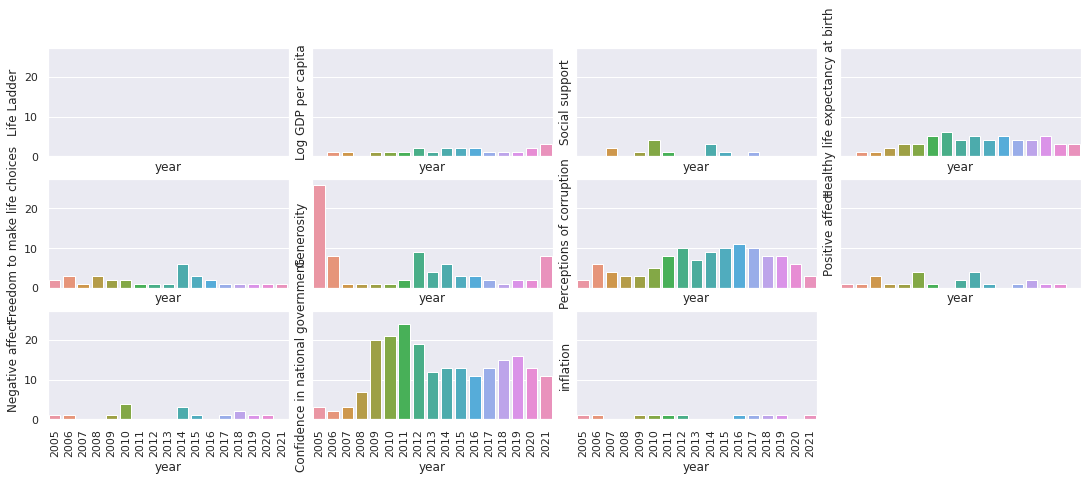

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
null_in_years = current_wh.set_index("year").isnull().groupby("year").sum().reset_index()
null_in_years
for ax, col in zip(axs.flat, null_in_years.drop(columns=["Country name", "year"]).columns):
    barplt = sns.barplot(
        data=null_in_years,
        x="year",
        y=col,
        ax=ax
    )
    barplt.set_xticklabels(barplt.get_xticklabels(),rotation=90)

fig.delaxes(axs[2,3])

### Distribution of Nulls in Countries
From below table and graphs, it can bee seen that most countries have little to no missing values.

In [18]:
null_pcts = (
        current_wh.drop(columns=["year"])\
        .set_index(["Country name"]).isnull()\
        .groupby("Country name").sum()
    ).div(
        current_wh.set_index(["Country name"])\
        .groupby("Country name").count()["year"]
        ,axis="index"
    )
null_pcts[(null_pcts.max(axis=1)>0)]

Life Ladder  Log GDP per capita  Social support  \
Country name                                                                
Afghanistan                       0.0            0.076923        0.000000   
Albania                           0.0            0.000000        0.000000   
Algeria                           0.0            0.000000        0.100000   
Argentina                         0.0            0.000000        0.000000   
Australia                         0.0            0.000000        0.000000   
Bahrain                           0.0            0.000000        0.090909   
Bangladesh                        0.0            0.000000        0.000000   
Belarus                           0.0            0.000000        0.000000   
Belgium                           0.0            0.000000        0.000000   
Bosnia and Herzegovina            0.0            0.000000        0.000000   
Brazil                            0.0            0.000000        0.000000   
Burundi                           0.0            0.000000        0.000000   
Cambodia                          0.0            0.000000        0.000000   
Canada                            0.0            0.000000        0.062500   
China                             0.0            0.000000        0.000000   
Comoros                           0.0            0.000000        0.000000   
Congo (Brazzaville)               0.0            0.000000        0.000000   
Congo (Kinshasa)                  0.0            0.000000        0.000000   
Croatia                           0.0            0.000000        0.000000   
Cuba                              0.0            1.000000        0.000000   
Cyprus                            0.0            0.000000        0.000000   
Czechia                           0.0            0.000000        0.000000   
Denmark                           0.0            0.000000        0.000000   
Djibouti                          0.0            0.000000        0.250000   
Egypt                             0.0            0.000000        0.000000   
Ethiopia                          0.0            0.000000        0.000000   
France                            0.0            0.000000        0.000000   
Gabon                             0.0            0.000000        0.000000   
Germany                           0.0            0.000000        0.000000   
Greece                            0.0            0.000000        0.000000   
Guinea                            0.0            0.000000        0.000000   
Hong Kong                         0.0            0.000000        0.000000   
Hungary                           0.0            0.000000        0.000000   
Iceland                           0.0            0.000000        0.000000   
India                             0.0            0.000000        0.000000   
Iran                              0.0            0.000000        0.000000   
Iraq                              0.0            0.000000        0.000000   
Israel                            0.0            0.000000        0.000000   
Italy                             0.0            0.000000        0.000000   
Japan                             0.0            0.000000        0.000000   
Jordan                            0.0            0.000000        0.000000   
Kosovo                            0.0            0.066667        0.000000   
Kuwait                            0.0            0.000000        0.090909   
Laos                              0.0            0.000000        0.000000   
Lebanon                           0.0            0.000000        0.000000   
Libya                             0.0            0.000000        0.000000   
Madagascar                        0.0            0.000000        0.000000   
Maldives                          0.0            0.000000        0.000000   
Malta                             0.0            0.000000        0.000000   
Mexico                            0.0            0.000000        0.000000   
Montenegro            

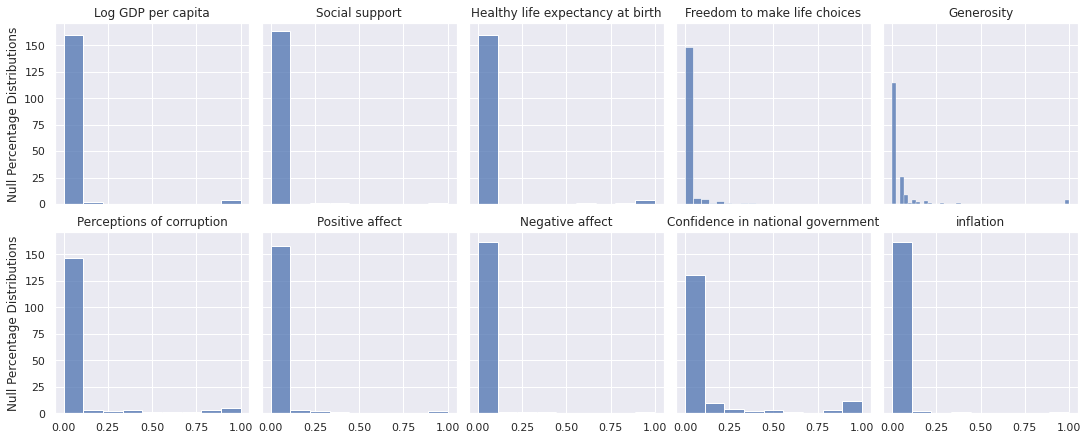

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
for ax, col in zip(axs.flat, null_pcts.drop(columns=["Life Ladder"]).columns):
    histplt = sns.histplot(
        data=null_pcts,
        x=col,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Null Percentage Distributions")

 In table there are some countries who have obviously more missing values in 'Perception of Corruption' AND/OR 'Confidence in National Government' than in any other field. For example, China has mostly complete data (except for 'Freedom to make life choices' and 'Generosity'). But for the two columns in focus, all data points are empty. I believe this has something to do with the social/democratic practices in the country. In the table below, more such countries are listed.

In [20]:
null_pcts[(null_pcts["Perceptions of corruption"]>=0.5) | (null_pcts["Confidence in national government"]>=0.5)]

Life Ladder  Log GDP per capita  Social support  \
Country name                                                            
Algeria                       0.0                 0.0        0.100000   
Bahrain                       0.0                 0.0        0.090909   
China                         0.0                 0.0        0.000000   
Cuba                          0.0                 1.0        0.000000   
Egypt                         0.0                 0.0        0.000000   
Jordan                        0.0                 0.0        0.000000   
Kuwait                        0.0                 0.0        0.090909   
Laos                          0.0                 0.0        0.000000   
Libya                         0.0                 0.0        0.000000   
Maldives                      0.0                 0.0        0.000000   
Morocco                       0.0                 0.0        0.090909   
Oman                          0.0                 0.0        1.000000   
Qatar                         0.0                 0.0        0.400000   
Saudi Arabia                  0.0                 0.0        0.000000   
Sudan                         0.0                 0.0        0.000000   
Syria                         0.0                 0.0        0.000000   
Turkmenistan                  0.0                 0.0        0.000000   
United Arab Emirates          0.0                 0.0        0.071429   
Vietnam                       0.0                 0.0        0.062500   

                      Healthy life expectancy at birth  \
Country name                                             
Algeria                                            0.0   
Bahrain                                            0.0   
China                                              0.0   
Cuba                                               0.0   
Egypt                                              0.0   
Jordan                                             0.0   
Kuwait                                             0.0   
Laos                                               0.0   
Libya                                              0.0   
Maldives                                           0.0   
Morocco                                            0.0   
Oman                                               0.0   
Qatar                                              0.0   
Saudi Arabia                                       0.0   
Sudan                                              0.0   
Syria                                              0.0   
Turkmenistan                                       0.0   
United Arab Emirates                               0.0   
Vietnam                                            0.0   

                      Freedom to make life choices  Generosity  \
Country name                                                     
Algeria                                   0.200000    0.200000   
Bahrain                                   0.090909    0.272727   
China                                     0.312500    0.062500   
Cuba                                      0.000000    1.000000   
Egypt                                     0.062500    0.062500   
Jordan                                    0.125000    0.062500   
Kuwait                                    0.090909    0.363636   
Laos                                      0.100000    0.000000   
Libya                                     0.000000    0.000000   
Maldives                                  0.000000    0.000000   
Morocco                                   0.000000    0.000000   
Oman                                      0.000000    0.000000   
Qatar                                     0.400000    0.200000   
Saudi Arabia                              0.062500    0.062500   
Sudan                                     0.000000    0.000000   
Syria                                     0.000000    0.000000   
Turkmenistan                              0.200000    0.000000   
United Arab Emi

### Countries with Many Nulls
To fill the missing data, at first, at least linear models will be used. Hence per variable and country, we need at least 2 data points to infer. Let us see the countries, which **do not** meet this criteria!

In [21]:
not_null_counts = (
        current_wh.drop(columns=["year"])\
        .set_index(["Country name"]).notna()
        .groupby("Country name").sum()
    )
many_null_filter = (not_null_counts.min(axis=1) < 2) & (null_pcts.max(axis=1) >= 0.5)
not_null_counts[many_null_filter]

Life Ladder  Log GDP per capita  Social support  \
Country name                                                            
Algeria                        10                  10               9   
Bahrain                        11                  11              10   
China                          16                  16              16   
Cuba                            1                   0               1   
Hong Kong                      12                  12              12   
Kosovo                         15                  14              15   
Kuwait                         11                  11              10   
Libya                           6                   6               6   
Maldives                        1                   1               1   
North Cyprus                    7                   0               7   
Oman                            1                   1               0   
Qatar                           5                   5               3   
Saudi Arabia                   16                  16              16   
Somaliland region               4                   0               4   
South Sudan                     4                   0               4   
Sudan                           5                   5               5   
Syria                           7                   7               7   
Turkmenistan                   10                  10              10   
United Arab Emirates           14                  14              13   

                      Healthy life expectancy at birth  \
Country name                                             
Algeria                                             10   
Bahrain                                             11   
China                                               16   
Cuba                                                 1   
Hong Kong                                            0   
Kosovo                                               0   
Kuwait                                              11   
Libya                                                6   
Maldives                                             1   
North Cyprus                                         0   
Oman                                                 1   
Qatar                                                5   
Saudi Arabia                                        16   
Somaliland region                                    0   
South Sudan                                          4   
Sudan                                                5   
Syria                                                7   
Turkmenistan                                        10   
United Arab Emirates                                14   

                      Freedom to make life choices  Generosity  \
Country name                                                     
Algeria                                          8           8   
Bahrain                                         10           8   
China                                           11          15   
Cuba                                             1           0   
Hong Kong                                       12          11   
Kosovo                                          14          13   
Kuwait                                          10           7   
Libya                                            6           6   
Maldives                                         1           1   
North Cyprus                                     7           0   
Oman                                             1           1   
Qatar                                            3           4   
Saudi Arabia                                    15          15   
Somaliland region                                4           0   
South Sudan                                      4           0   
Sudan                                            5           5   
Syria                                            7           7   
Turkmenistan   

# Imputing Nulls
For imputation sklearn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer">IterativeImputer</a> will be used. It iteratively imputes each column using the other columns as predictors.

One important point is that the happiness score will not be used in this process, to prevent data leakage.

Before filling the nulls, first let us save the observed dataset, in case it is needed in the future.

In [22]:
current_wh.to_csv("data/current_wh_2022_observed.csv")

Minimum and maximum values for the imputations are defined below. Except for inflation, 0 is OK to set as the lower limit. For the upper one, GDP, healthy life expectancy and inflation should not be limited, and for the rest, 1 should work fine.

In [23]:
cols_to_impute = current_wh.drop(["Life Ladder","Country name"],axis=1).columns
min_val = [
    0 if col not in ["inflation","Generosity"] else -np.inf
    for col in cols_to_impute
]
max_val = [
    1 if col not in ["Log GDP per capita","Healthy life expectancy at birth","inflation"] else np.inf
    for col in cols_to_impute
]

Imputation is done and the dataset is updated with those values!

In [24]:
itimp = IterativeImputer(min_value=min_val, max_value=max_val, max_iter=10, random_state=0)
cluster_imp = itimp.fit_transform(current_wh.drop(["Life Ladder","Country name"],axis=1))
cluster_imp = pd.DataFrame(cluster_imp, columns=cols_to_impute, index=current_wh.index)
current_wh.loc[current_wh.index, cols_to_impute] = cluster_imp

Any null values in the data?

In [25]:
current_wh.isna().any().any()

False

### Visual Checks on Imputation Results


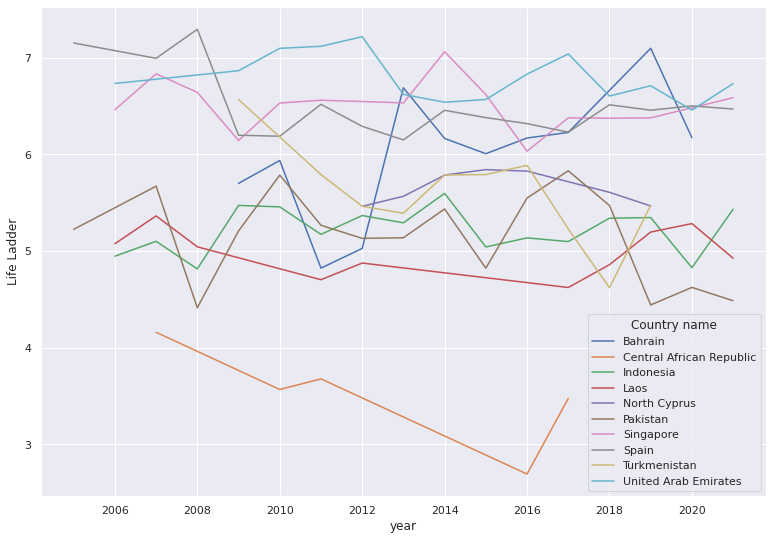

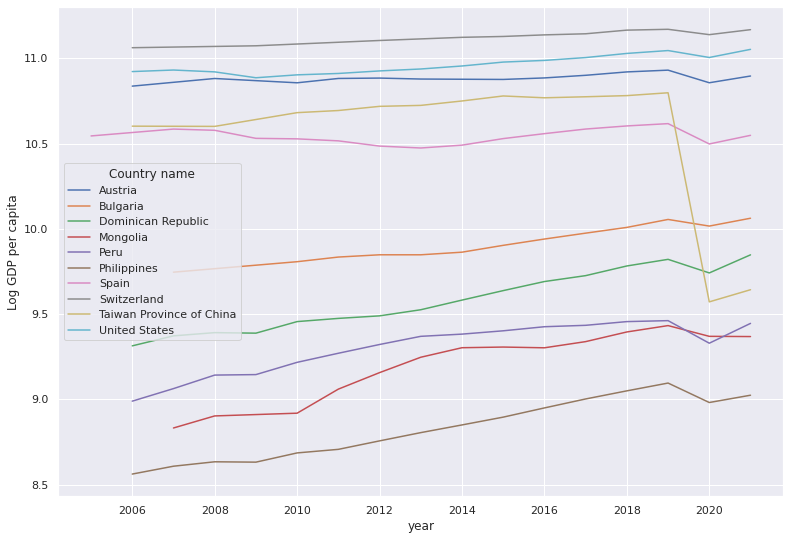

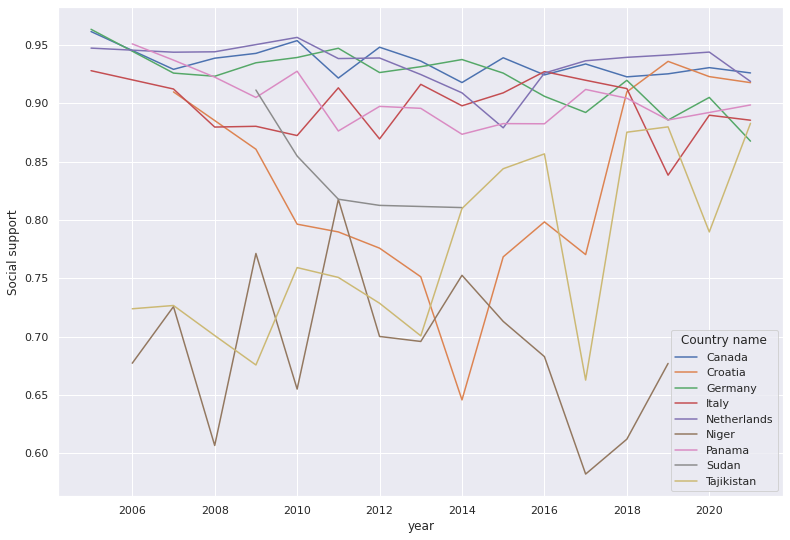

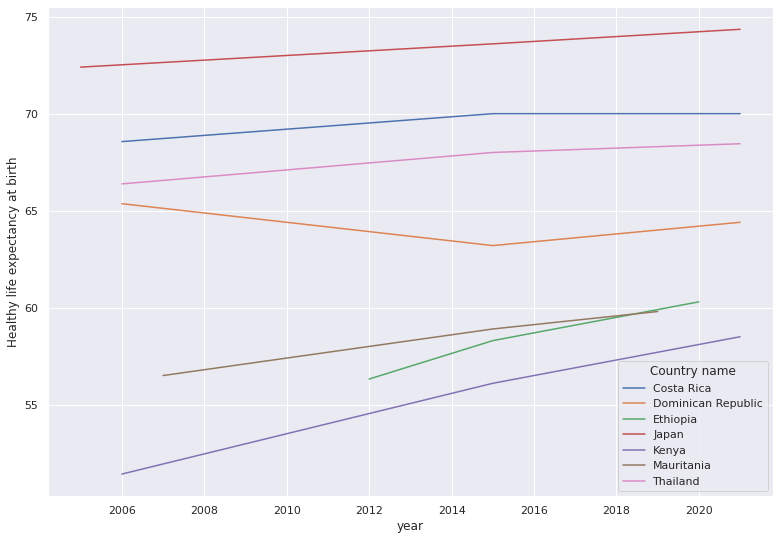

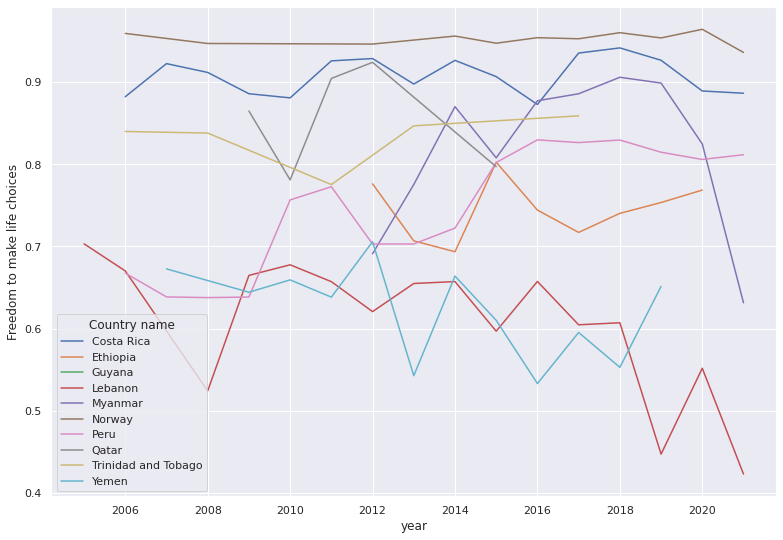

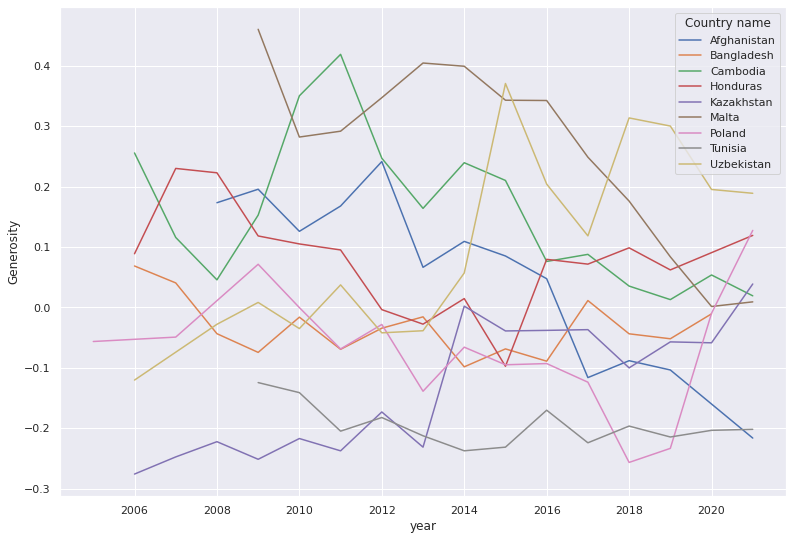

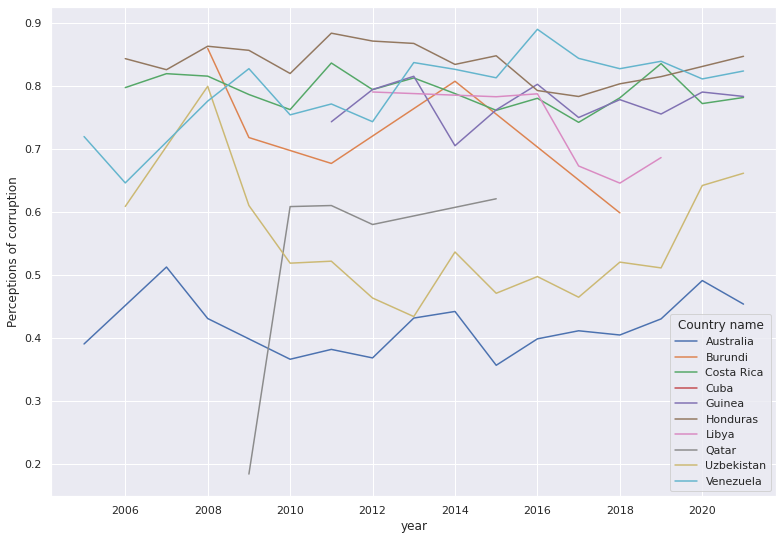

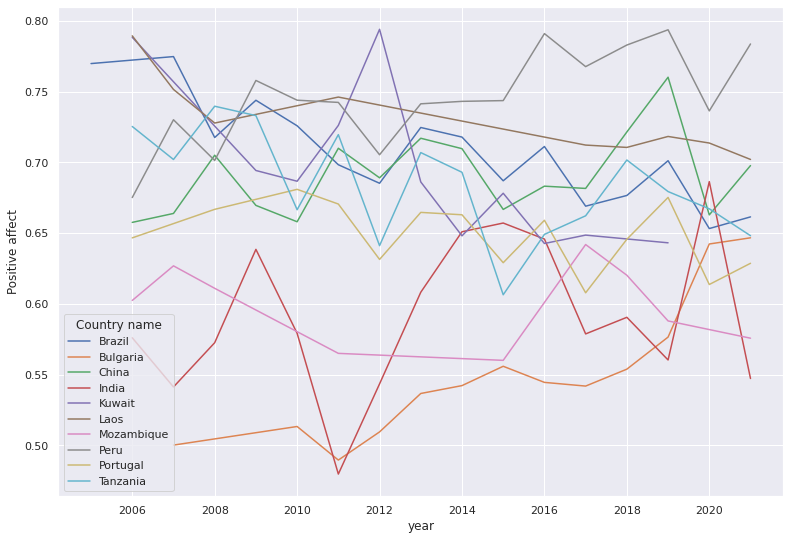

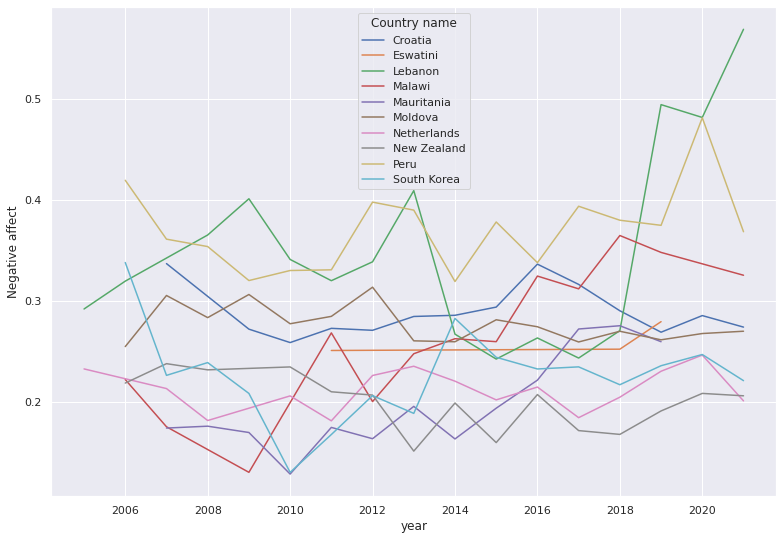

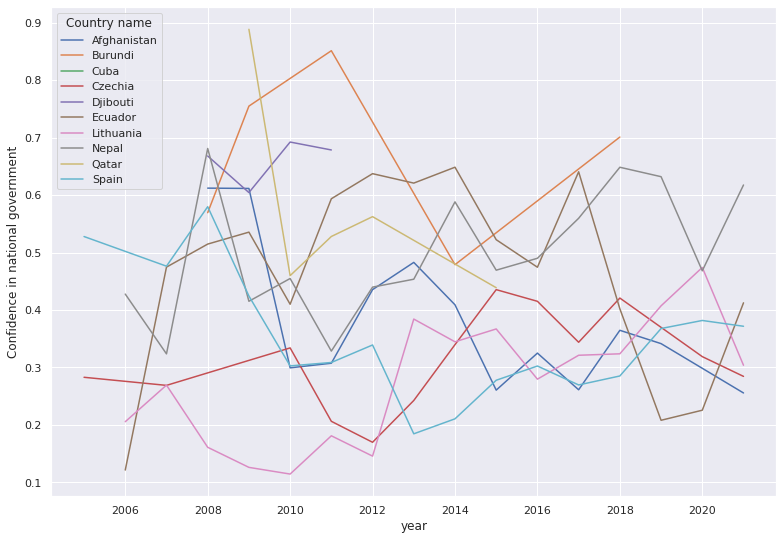

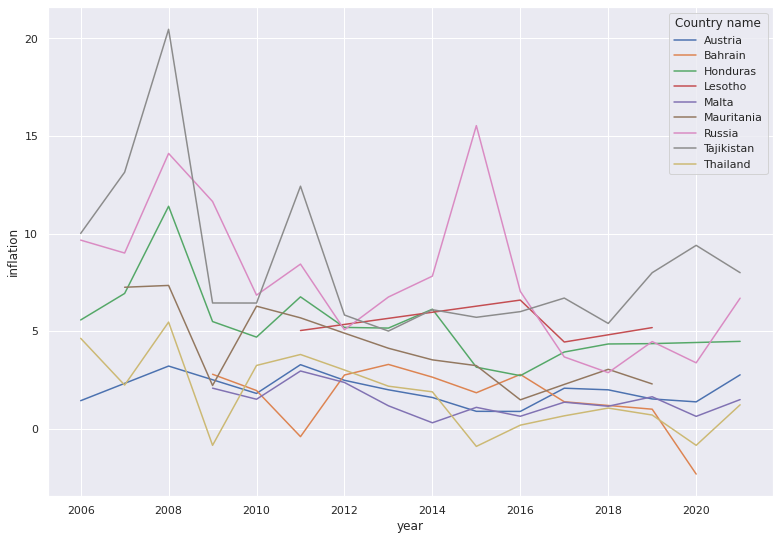

In [26]:
for variable in current_wh.columns.drop(["Country name","year"]):
    countries = random.choices(current_wh["Country name"].unique(), k=10)
    plot_data = current_wh[current_wh["Country name"].isin(countries)][["Country name", "year", variable]]
    plt.figure(variable)
    sns.lineplot(
        data=plot_data,
        x="year",
        y=variable,
        hue="Country name"
    )

In [27]:
current_wh.to_csv("data/full_wh22.csv")

In [1]:
current_wh[current_wh["Healthy life expectancy at birth"]<40]

NameError: name 'current_wh' is not defined